In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Data used to rescale results to actual scale.
max_covid_confirmed_by_country_csv = '/content/gdrive/MyDrive/Covid_Project/Data/Processed_Data/max_covid_confirmed_by_country.csv'
max_covid_confirmed_by_country_df = pd.read_csv(max_covid_confirmed_by_country_csv, index_col='Country/Region')
max_covid_confirmed_by_country_dict = max_covid_confirmed_by_country_df.to_dict()

In [4]:
# Load training data.

# Specify the region to train.
regions = ['asia', 'africa', 'europe', 'north_america', 'oceania', 'south_america']
region = 'south_america'

path_for_training_data = '/content/gdrive/MyDrive/Covid_Project/Data/Training_Data/' + region + '_training_data.json'
with open(path_for_training_data) as f:
    data = json.load(f)

In [5]:
countries_name = data['countries_name']
population_data = data['population_data']
# Last dim (with shape 3) corresponds to (covid_cases, fully_vaccinated, partially_vaccinated)
data_inputs = data['training_data_inputs']
data_labels = data['training_data_labels']

In [6]:
data_inputs_np = np.array(data_inputs)
data_labels_np = np.array(data_labels)

In [7]:
# Check for right dimensions.
assert(data_inputs_np.shape[1:] == (569, 3))

In [12]:
# Split the data in training and validation.

num_total_example = data_inputs_np.shape[0]
print('Number of total examples ->', num_total_example)

training_indexes = np.arange(num_total_example)
np.random.shuffle(training_indexes)

training_split = int(0.7 * len(training_indexes))
indexes_for_training = training_indexes[0:training_split]
indexes_for_validation = training_indexes[training_split:]

training_inputs_np = data_inputs_np[indexes_for_training]
training_labels_np = data_labels_np[indexes_for_training]

validation_inputs_np = data_inputs_np[indexes_for_training]
validation_labels_np = data_labels_np[indexes_for_validation]

print('Number of training examples ->', training_split)
print('Number of validation examples ->', num_total_example - training_split)

Number of total examples -> 12
Number of training examples -> 8
Number of validation examples -> 4


In [13]:
# To show some training example.
def training_example(example_num):
    input_data = training_inputs_np[np.newaxis, example_num]
    output_data = training_labels_np[np.newaxis, example_num]

    plt.figure(figsize=(20, 4))
    plt.plot(input_data[0,:, 0], label='cases.')
    plt.plot(input_data[0,:, 1], label='fully vaccinated.')
    plt.plot(input_data[0,:, 2], label='partially vaccinated.')
    
    plt.plot(output_data[0, :, 0], label= 'output.')
    plt.legend(loc='best')
    plt.show()

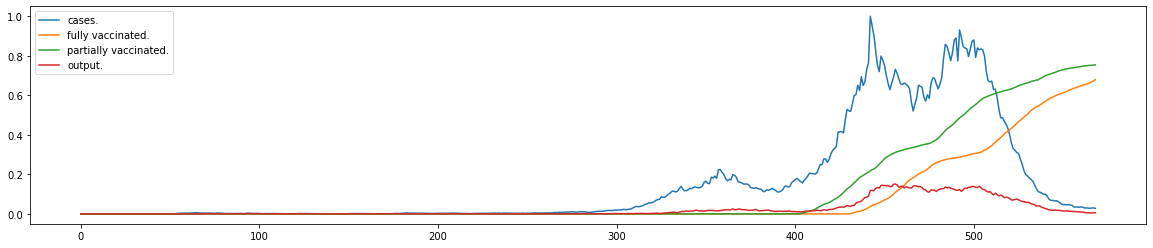

In [14]:
training_example(0) 

In [15]:
model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(569, 3)),
        tf.keras.layers.LSTM(units=32, return_sequences=True),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(1),
        ])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 569, 32)           4608      
_________________________________________________________________
dense (Dense)                (None, 569, 32)           1056      
_________________________________________________________________
dense_1 (Dense)              (None, 569, 1)            33        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [17]:
loss_weights = [1] * 300 + [3] * (569 - 300)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=['mean_absolute_percentage_error'],
              loss_weights=loss_weights)


history = model.fit(x=training_inputs, y=training_labels, epochs=100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0203 - mean_absolute_percentage_error: 1184.0499
Epoch 2/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0165 - mean_absolute_percentage_error: 1395955.3750
Epoch 3/100
1/1 [==============================] - 0s 75ms/step - loss: 0.0143 - mean_absolute_percentage_error: 2746600.0000
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0133 - mean_absolute_percentage_error: 3999272.0000
Epoch 5/100
1/1 [==============================] - 0s 76ms/step - loss: 0.0134 - mean_absolute_percentage_error: 5043059.0000
Epoch 6/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0140 - mean_absolute_percentage_error: 5728320.0000
Epoch 7/100
1/1 [==============================] - 0s 82ms/step - loss: 0.0145 - mean_absolute_percentage_error: 5992167.0000
Epoch 8/100
1/1 [==============================] - 0s 86ms/step - loss: 0.0146 - mean_absolute_percentage_error: 5894550.50

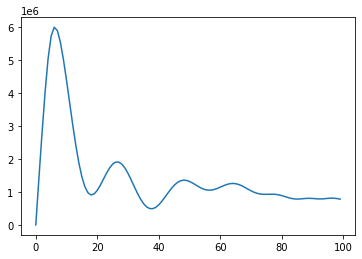

In [18]:
plt.plot(history.history['mean_absolute_percentage_error'])

In [34]:
def predict_training_example(example_num, country_name, type_of_data):
    if type_of_data == 'training data':
        input_data = training_inputs_np[np.newaxis, example_num]
        output_data = training_labels_np[np.newaxis, example_num]
    else:
        input_data = validation_inputs_np[np.newaxis, example_num]
        output_data = validation_labels_np[np.newaxis, example_num]
    predicted_data = model.predict(input_data)

    fully_vaccinated_data = input_data[0, :, 1]
    partially_vaccinated_data = input_data[0, :, 2]

    # Rescale
    cases = input_data[0, :, 0] * max_covid_confirmed_by_country_dict['0'][country_name]
    predicted = predicted_data[0, :, 0] * max_covid_confirmed_by_country_dict['0'][country_name] / 10
    output = output_data[0, :, 0] * max_covid_confirmed_by_country_dict['0'][country_name] / 10

    SSD = np.sum((output - predicted) ** 2)
    RSE = np.sqrt(SSD / (len(predicted) - 1))
    error = RSE / np.mean(output)

    print(country_name, '    -----    ', 'error =', error * 100, '%', '    -----    ', type_of_data)

    # Plot training example.
    plt.figure(figsize=(20, 4))
    plt.plot(cases / 40, label='covid cases.', color="b")
    plt.plot(predicted, label='predicted deaths.', color="g")
    plt.plot(output, label= 'real deaths.', color="r")
    plt.legend(loc='best')
    plt.show()

    # Plot vaccination.
    plt.figure(figsize=(20, 4))
    plt.plot(fully_vaccinated_data, label='fully vaccinated.')
    plt.plot(partially_vaccinated_data, label='partially vaccinated.')
    plt.legend(loc='best')
    plt.show()



Uruguay     -----     error = 274.1113482887554 %     -----     training data


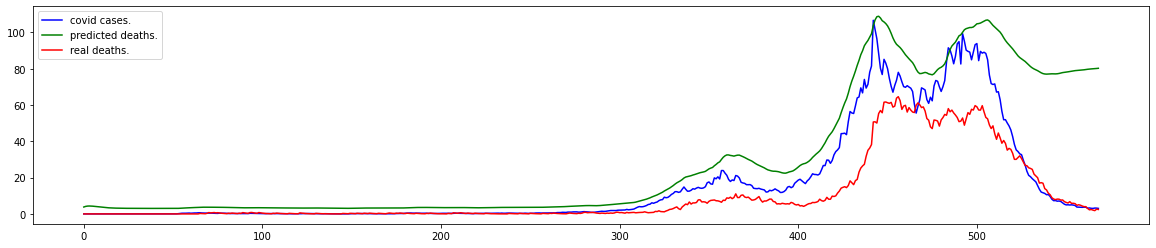

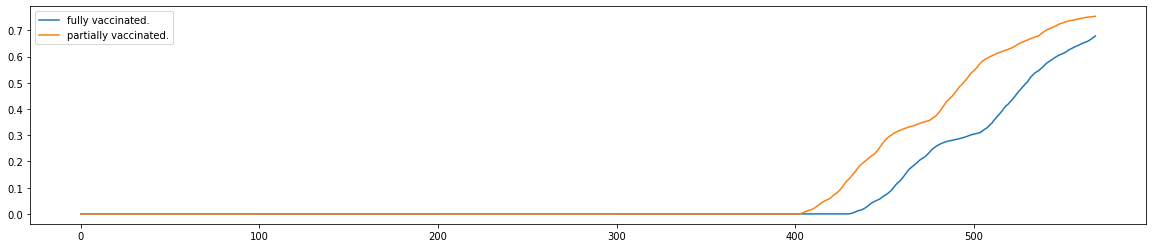

Ecuador     -----     error = 269.3215744023099 %     -----     training data


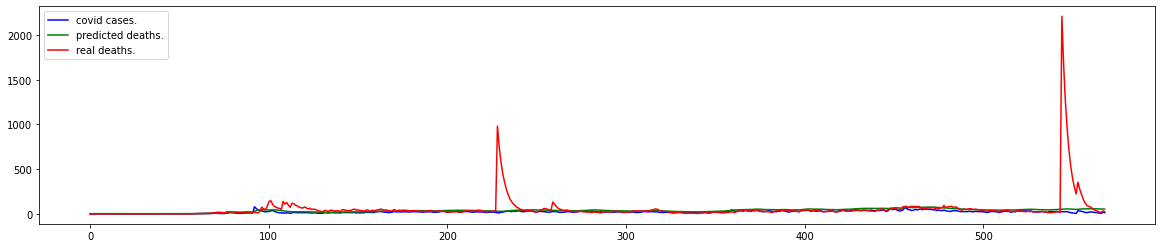

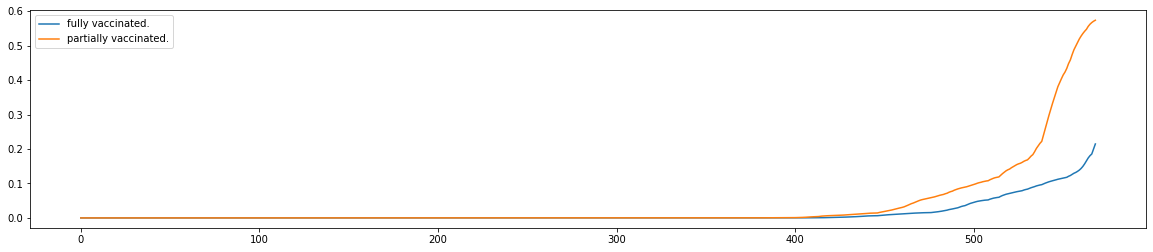

Paraguay     -----     error = 55.76557768901744 %     -----     training data


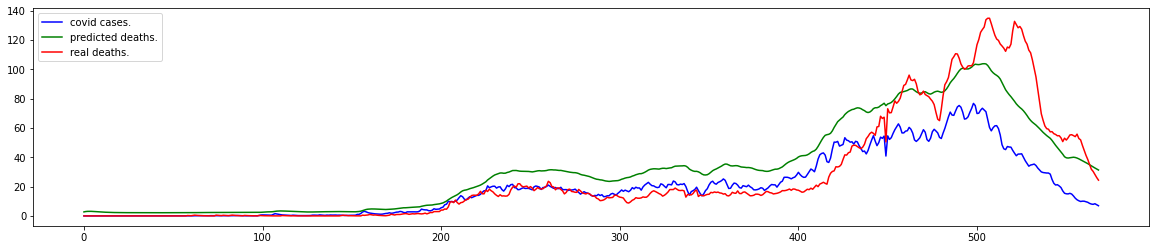

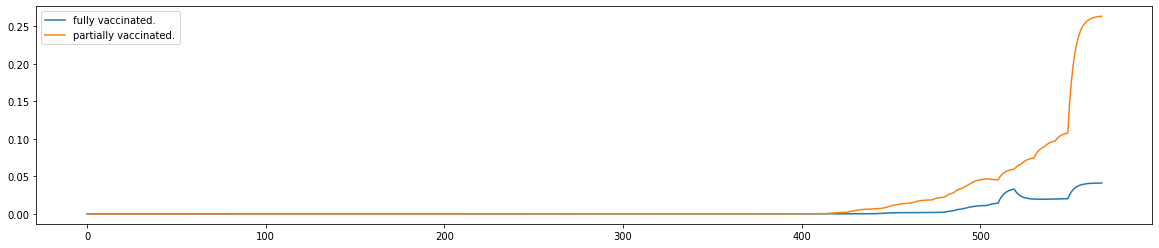

Suriname     -----     error = 76.30578895050004 %     -----     training data


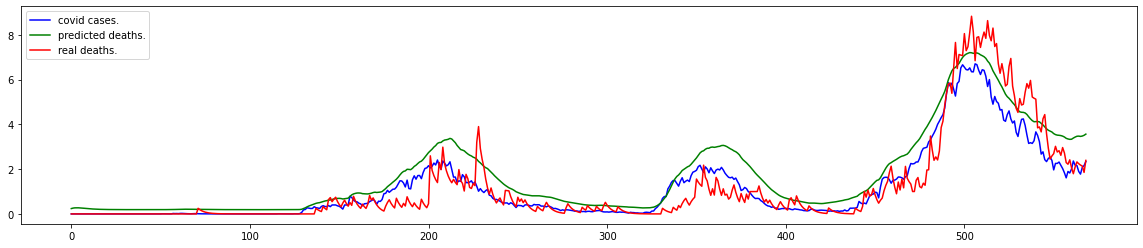

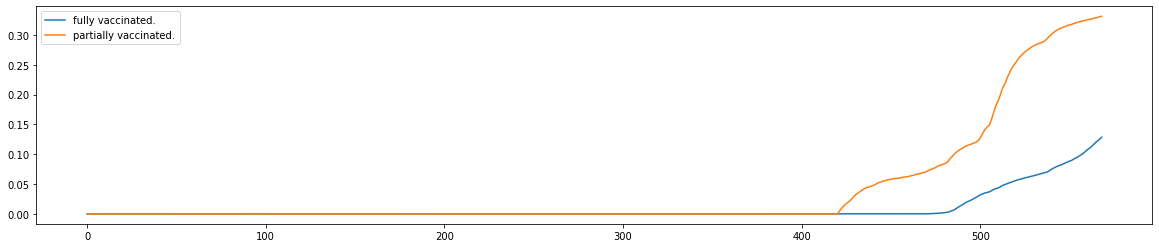

Colombia     -----     error = 56.83179421421761 %     -----     training data


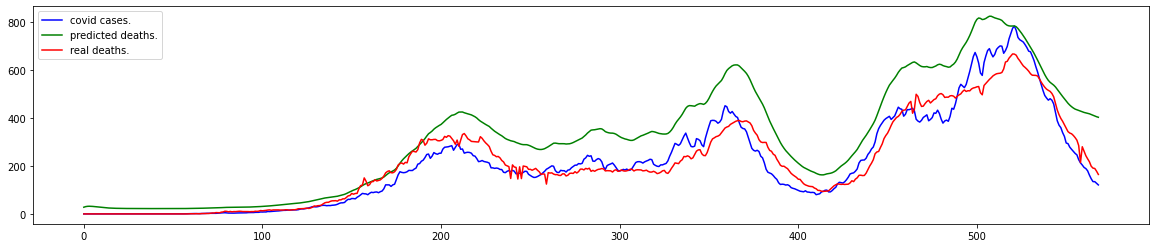

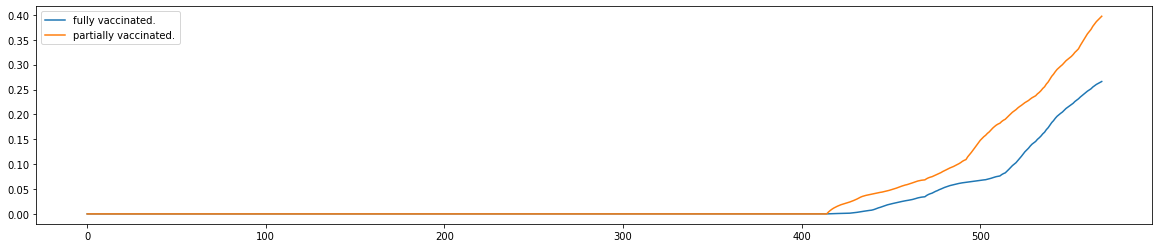

Guyana     -----     error = 70.37054340147114 %     -----     training data


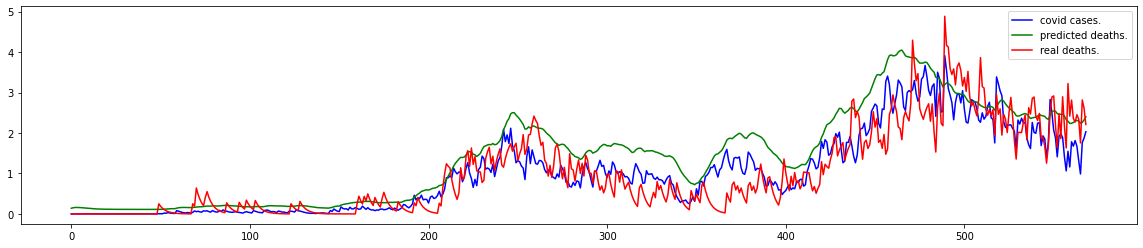

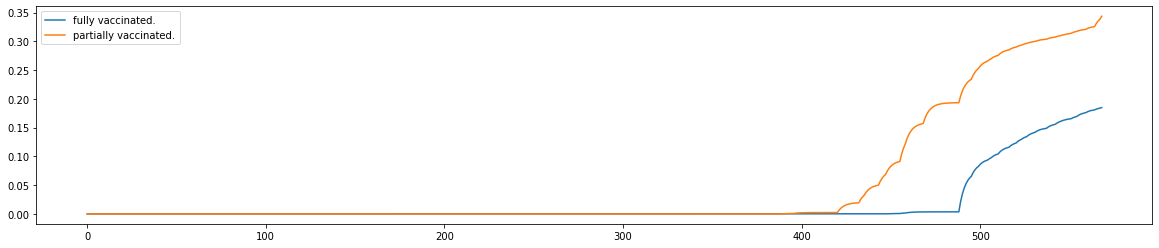

Venezuela     -----     error = 277.7646301620611 %     -----     training data


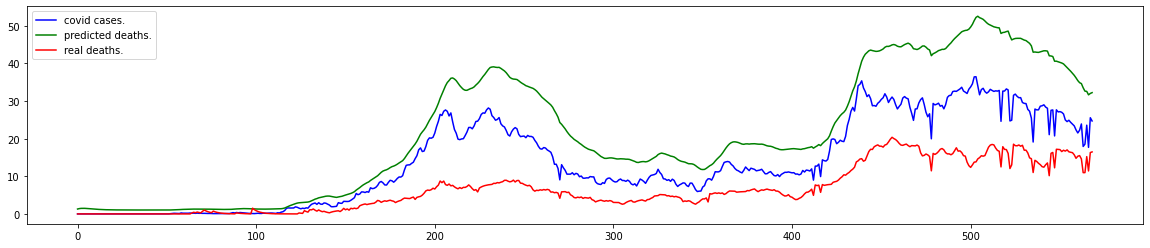

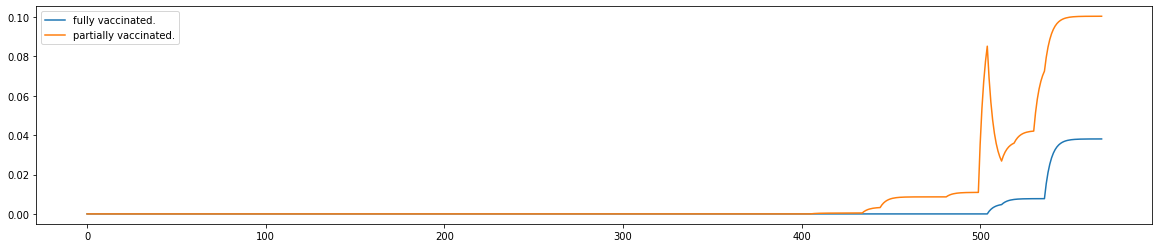

Argentina     -----     error = 95.52288717839001 %     -----     training data


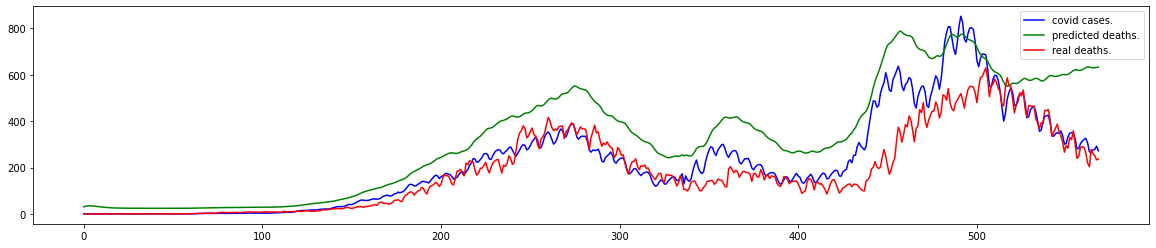

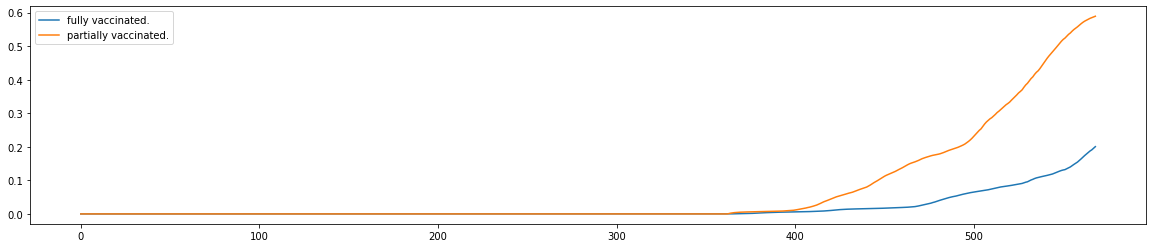

Brazil     -----     error = 63.093040030107005 %     -----     validation data


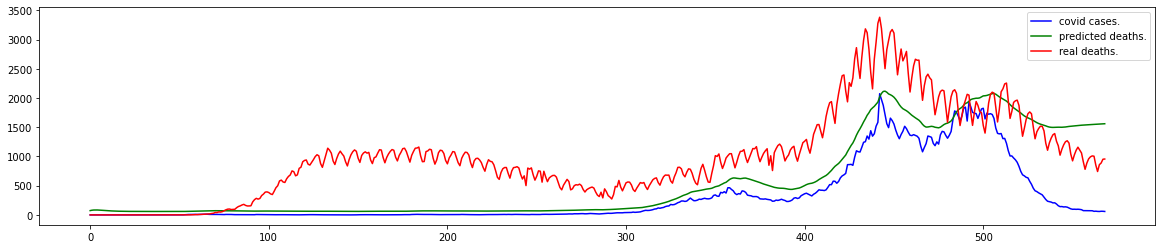

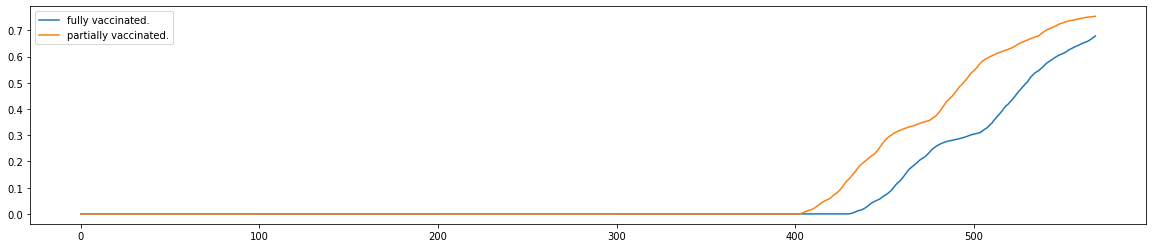

Chile     -----     error = 75.68665355398706 %     -----     validation data


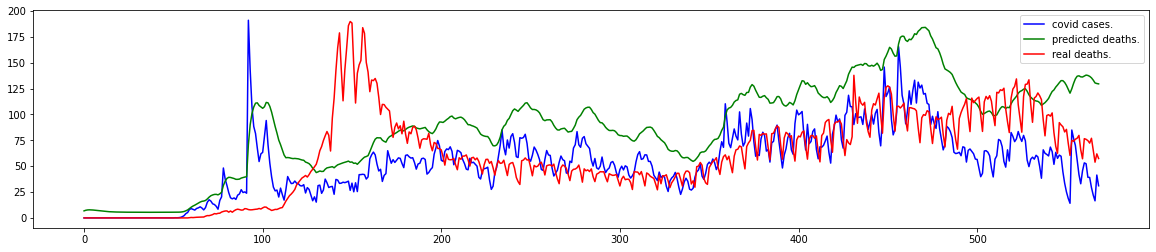

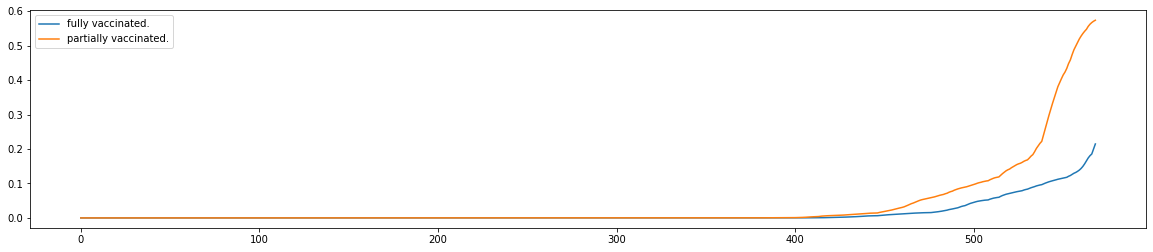

Peru     -----     error = 98.4739509816988 %     -----     validation data


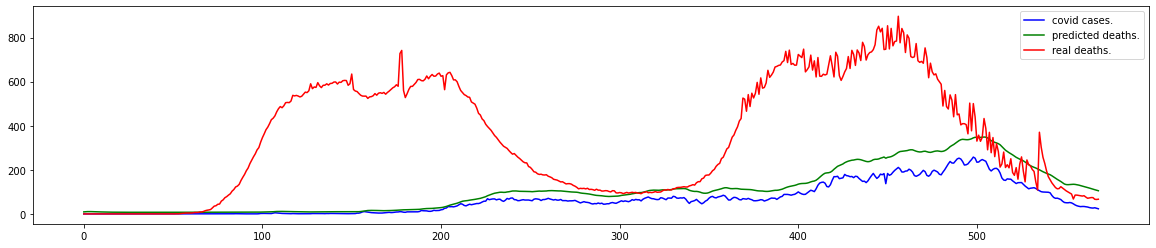

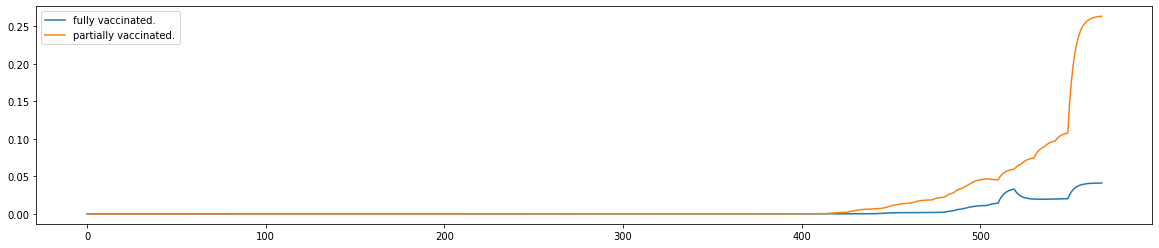

Bolivia     -----     error = 63.31038121911473 %     -----     validation data


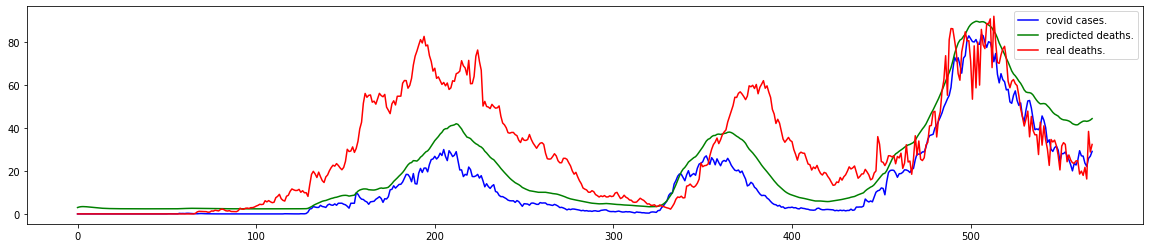

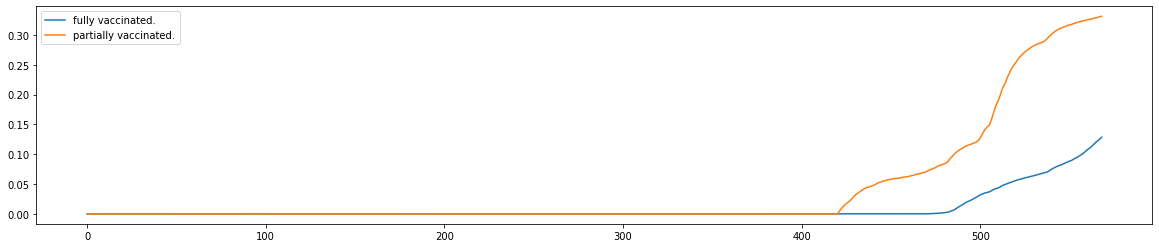

In [35]:
# Show training cases.
for i in range(training_split):
    idx = indexes_for_training[i]
    predict_training_example(i, countries_name[idx], 'training data')

# Show validation cases.
for i in range(num_total_example - training_split):
    idx = indexes_for_validation[i]
    predict_training_example(i, countries_name[idx], 'validation data')